In [1]:
import sys
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/CommonSwissBirds

/content/drive/MyDrive/CommonSwissBirds


In [4]:
%ls

01_data_prep/  03_base_model/  05_efficientNetV2L/   utils/
02_data/       04_resnet_50/   06_mobileNetV3_mini/


In [5]:
sys.path.append('./utils')
import utils

In [6]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: Tesla T4 (UUID: GPU-8c2fea83-f8a5-66f9-e670-04208ed3b6c3)


In [7]:
class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/test_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)

Found 1222 files belonging to 10 classes.


In [11]:
showcase_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/showcase_images',
    labels='inferred',
    label_mode='int',
    class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube'],
    color_mode='rgb',
    shuffle=False,
    batch_size=30,
    image_size=(224, 224),
)

Found 30 files belonging to 10 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
showcase_ds = showcase_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
base_model = EfficientNetV2L(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)

473176280/473176280 [==============================] - 3s 0us/step


In [19]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./05_efficientNetV2L/model/best.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [20]:
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks],
)

Epoch 1/50
125/125 [==============================] - 624s 5s/step - loss: 0.4760 - accuracy: 0.8378 - val_loss: 0.2095 - val_accuracy: 0.9340
Epoch 2/50
125/125 [==============================] - 71s 568ms/step - loss: 0.1808 - accuracy: 0.9380 - val_loss: 0.1636 - val_accuracy: 0.9430
Epoch 3/50
125/125 [==============================] - 64s 507ms/step - loss: 0.1093 - accuracy: 0.9615 - val_loss: 0.1890 - val_accuracy: 0.9400
Epoch 4/50
125/125 [==============================] - 72s 570ms/step - loss: 0.0826 - accuracy: 0.9735 - val_loss: 0.1198 - val_accuracy: 0.9690
Epoch 5/50
125/125 [==============================] - 72s 569ms/step - loss: 0.0713 - accuracy: 0.9780 - val_loss: 0.0983 - val_accuracy: 0.9740
Epoch 6/50
125/125 [==============================] - 63s 505ms/step - loss: 0.0571 - accuracy: 0.9805 - val_loss: 0.1822 - val_accuracy: 0.9490
Epoch 7/50
125/125 [==============================] - 64s 509ms/step - loss: 0.0609 - accuracy: 0.9825 - val_loss: 0.1169 - val_accu

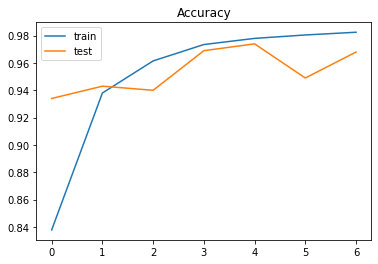

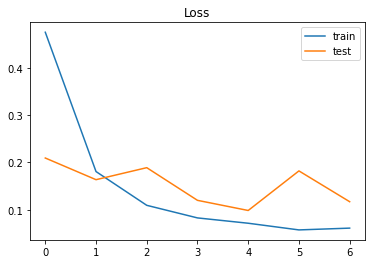

In [21]:
%matplotlib inline
utils.plot_history(history)

In [14]:
# Possible to start here without training... just loading the new weights...
base_model = EfficientNetV2L(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)
model.load_weights('./05_efficientNetV2L/model/best.h5')

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 146s 4s/step - loss: 0.2241 - accuracy: 0.9534
test loss, test acc: [0.22406837344169617, 0.9533551335334778]


In [27]:
testset_predictions = model.predict(test_ds)
predicted_labels = [prediction.argmax() for prediction in testset_predictions]
true_labels = utils.get_labels_from_categorical_batch_dataset(test_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

39/39 [==============================] - 19s 369ms/step


In [28]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.97      0.92      0.95       113
     blaumeise       0.99      0.81      0.89       125
      buchfink       0.98      0.98      0.98       125
        elster       0.95      1.00      0.97       113
hausrotschwanz       0.96      0.97      0.96       117
     hausspatz       0.97      0.98      0.97       133
     kohlmeise       0.81      0.99      0.89       125
   rabenkraehe       1.00      0.98      0.99       121
          star       0.97      0.94      0.96       125
  tuerkentaube       0.98      0.98      0.98       125

      accuracy                           0.95      1222
     macro avg       0.96      0.95      0.95      1222
  weighted avg       0.96      0.95      0.95      1222



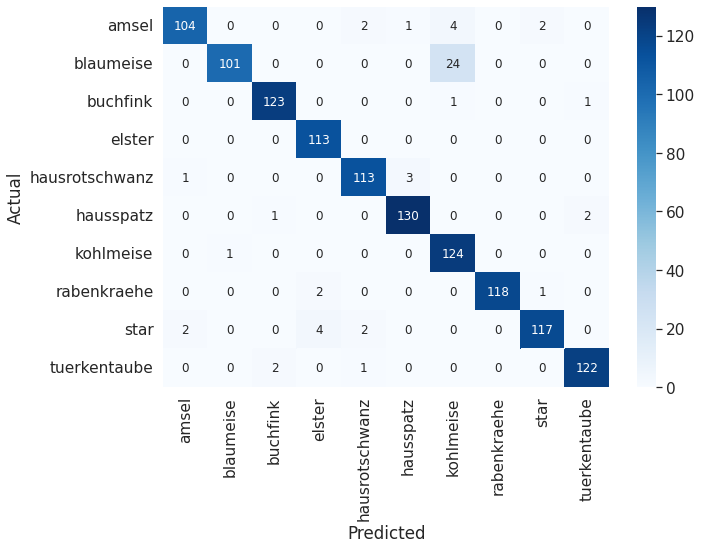

In [29]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

In [15]:
showcase_predictions = model.predict(showcase_ds)
predicted_labels = [prediction.argmax() for prediction in showcase_predictions]
true_labels = [label.numpy() for label in [labels for images, labels in showcase_ds.take(1)][0]]
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 17s 17s/step


In [16]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       1.00      1.00      1.00         3
     blaumeise       1.00      1.00      1.00         3
      buchfink       1.00      1.00      1.00         3
        elster       1.00      1.00      1.00         3
hausrotschwanz       1.00      1.00      1.00         3
     hausspatz       1.00      1.00      1.00         3
     kohlmeise       1.00      1.00      1.00         3
   rabenkraehe       1.00      1.00      1.00         3
          star       1.00      1.00      1.00         3
  tuerkentaube       1.00      1.00      1.00         3

      accuracy                           1.00        30
     macro avg       1.00      1.00      1.00        30
  weighted avg       1.00      1.00      1.00        30



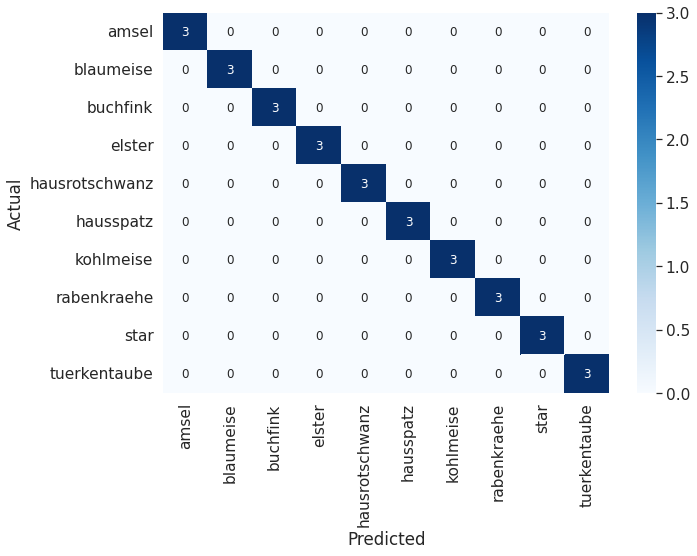

In [17]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

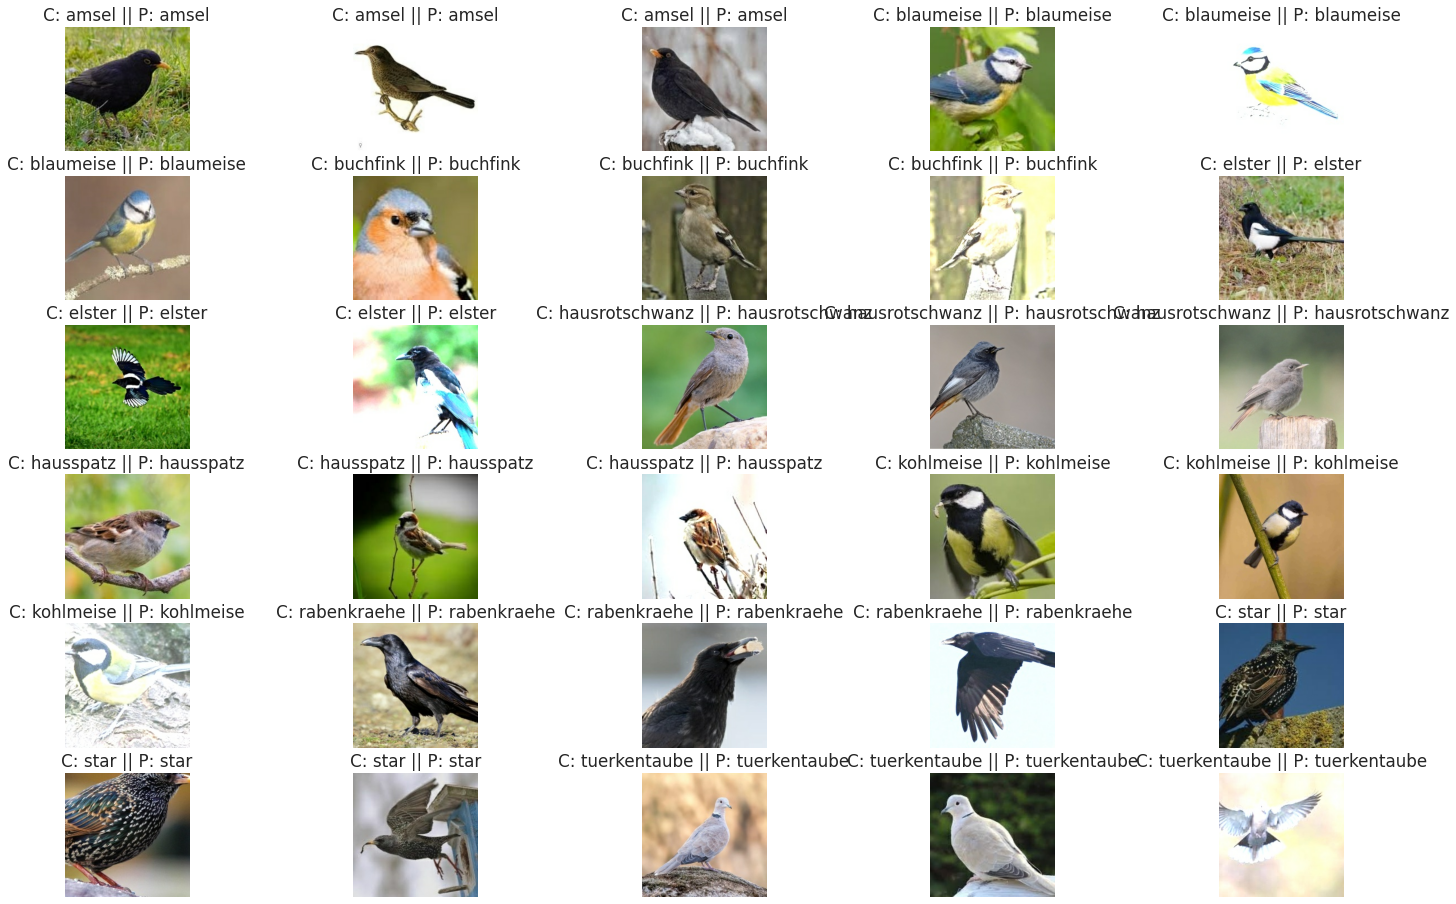

In [18]:
%matplotlib inline
utils.plot_showcase(showcase_ds, class_names, showcase_predictions)

# Grad-CAM
Showing important features of the image

Remarkable: It seems to look at many more details than mobilenet for example. That makes sense...

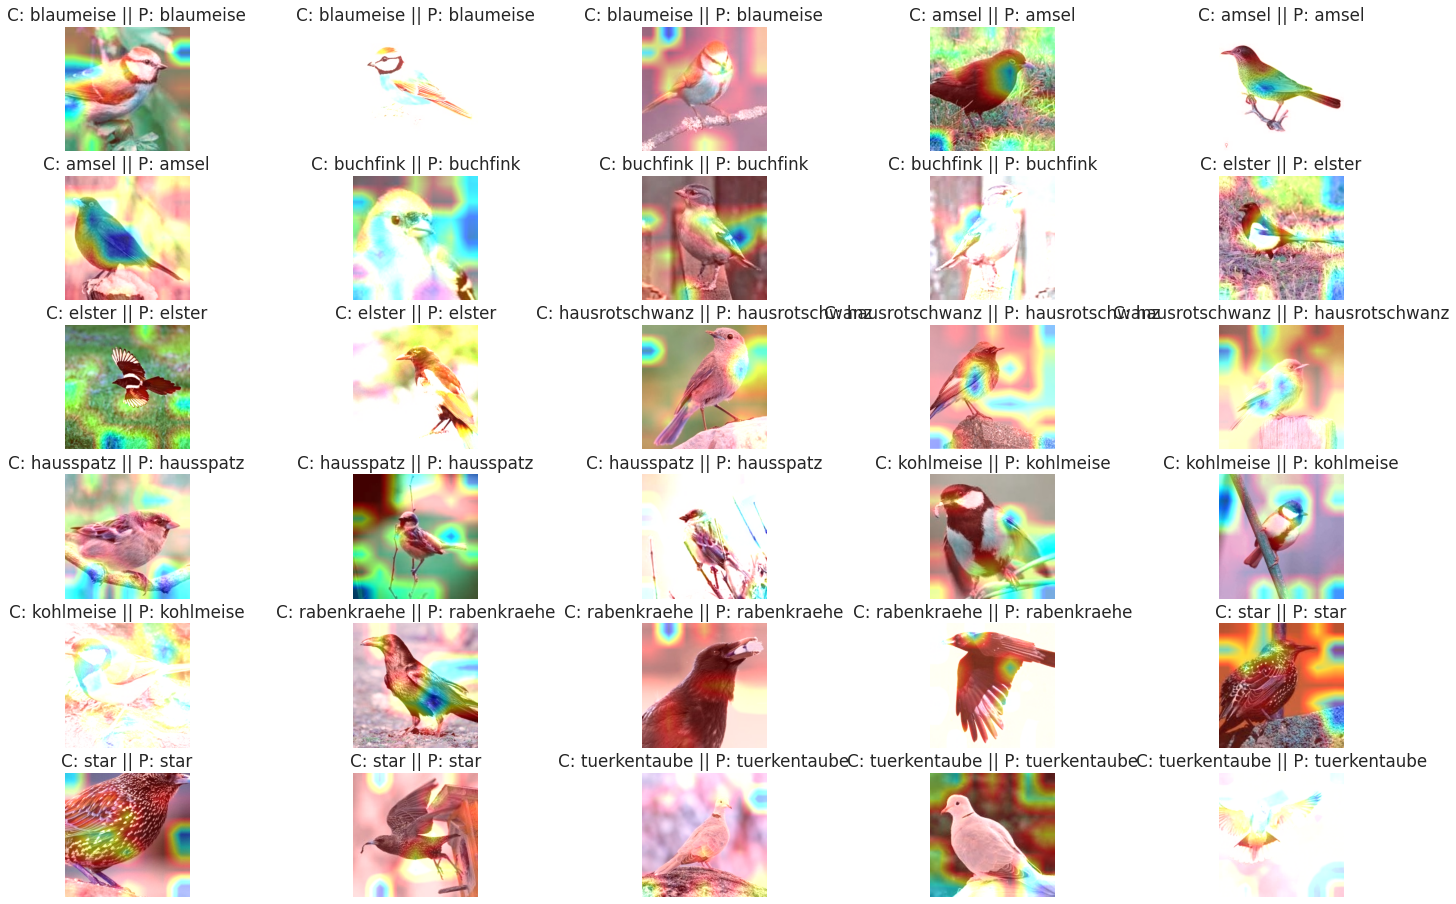

In [19]:
showcase_path = './02_data/99_dataset_preparation/showcase_images'
last_convolution_layer_name = 'block6x_project_conv'
utils.plot_showcase_gradcam_overlay(showcase_path, class_names, model, last_convolution_layer_name)

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling_1[0][0]']            
                                32)                                                         